## In this section, I will implement the MLP (“vanilla” neural network) on the MNIST dataset. And later the CNN using Pytorch. So what is MLP, CNN and the MNIST dataset?

 - MLP is a type of artificial neural network made up of multiple layers of nodes (neurons)

 - CNN is A Convolutional Neural Network — a type of deep learning model mainly for image/video analysis.

 - The MNIST dataset was constructed from two datasets of the US National Institute of Standards and
Technology (NIST). The training dataset consists of handwritten digits from 250 different people, 50
percent high school students, and 50 percent employees from the Census Bureau. Note that the test
dataset contains handwritten digits from different people following the same split.

### Lets download the dataset using keras instead fetch_openml function from sklearn because its not found (Ref1: https://github.com/ageron/handson-ml/issues/416) <br> (Ref2: https://www.kaggle.com/code/abdullah7aled/digit-recognizer-tutorial):

In [301]:
from tensorflow import keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [302]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [303]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [304]:
print(X_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


In [305]:
(X_train, y_train), (X_test, y_test) = (X_train.reshape(60000, 28*28), y_train), (X_test.reshape(10000, 28*28), y_test)

In [306]:
from sklearn.model_selection import train_test_split

# separate validation set (5,000 samples) from remaining data
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=5000, random_state=123, stratify=y_train
)

In [307]:
print(X_valid.shape)
print(y_valid.shape)

(5000, 784)
(5000,)


In [308]:
print(X_train.shape)
print(y_train.shape)

(55000, 784)
(55000,)


let’s normalize the pixels values in MNIST to the range –1 to 1 (originally 0 to 255)

In [309]:
X_train = ((X_train / 255.) - .5) * 2
X_valid = ((X_valid / 255.) - .5) * 2
X_test = ((X_test / 255.) - .5) * 2

### Lets see the images how they look like:

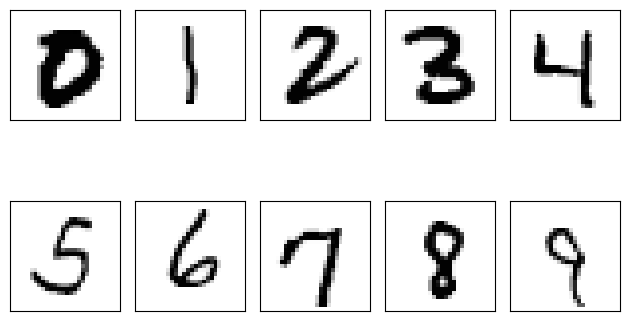

In [310]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5,
sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X_train[y_train == i][1].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

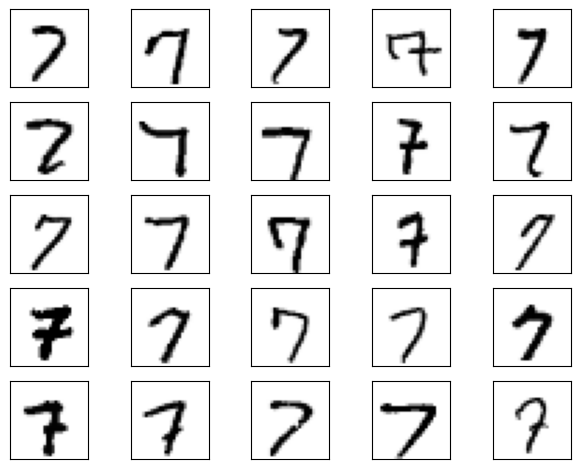

In [311]:
fig, ax = plt.subplots(nrows=5,
ncols=5,
sharex=True,
sharey=True)
ax = ax.flatten()

for i in range(25):
  img = X_train[y_train == 7][i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

### I will now implement an MLP from scratch to classify the images in the MNIST dataset.

## 1. Sigmoid Function

The **sigmoid function** is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

**Purpose**:
- Maps any real number to a value between \( 0 \) and \( 1 \).
- Commonly used as an activation function in neural networks for binary classification.

**Properties**:
$$
\sigma(z) \in (0, 1), \quad \sigma(0) = 0.5
$$
$$
\frac{d\sigma}{dz} = \sigma(z) \cdot (1 - \sigma(z))
$$

---

## 2. One-Hot Encoding

Given a class label \( y_i \) (integer) and the total number of classes \( K \),  
the **one-hot encoded vector** is:

$$
v_j =
\begin{cases}
1 & \text{if } j = y_i \\
0 & \text{otherwise}
\end{cases}
$$



**Example**:

If \( y = [2, 0, 1] \) and \( K = 4 \):

$$
\text{One-hot} =
\begin{bmatrix}
0 & 0 & 1 & 0 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$


In [312]:
import numpy as np

def sigmoid(z):
  return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
  ary = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    ary[i, val] = 1
    return ary

## Neural Network Implementation: 2-Layer MLP with Backpropagation

This notebook explains a simple **Multi-Layer Perceptron (MLP)** implemented from scratch using NumPy. The model has:
- One **hidden layer** with sigmoid activation
- One **output layer** with sigmoid activation
- Uses **Mean Squared Error (MSE)** as loss
- Implements manual **forward and backward pass**

---

### 📘 Mathematical Formulation

#### Notation
- $ x \in \mathbb{R}^{n \times d} $: input batch ($ n $ examples, $ d $ features)
- $ W_h \in \mathbb{R}^{h \times d} $: hidden weights
- $ b_h \in \mathbb{R}^{h} $: hidden bias
- $ W_{out} \in \mathbb{R}^{c \times h} $: output weights
- $ b_{out} \in \mathbb{R}^{c} $: output bias
- $ h $: number of hidden units
- $ c $: number of classes
- $ y $: true labels (integers)

---

### 1. Forward Pass

#### Hidden Layer:
$$
z_h = x W_h^T + b_h \\
a_h = \sigma(z_h), \quad \sigma(z) = \frac{1}{1 + e^{-z}}
$$

#### Output Layer:
$$
z_{out} = a_h W_{out}^T + b_{out} \\
a_{out} = \sigma(z_{out})
$$

---

### 2. Loss Function (MSE)

One-hot encode labels:
$$
\hat{y} = \text{OneHot}(y)
$$

Mean Squared Error:
$$
\mathcal{L} = \frac{1}{n} \| a_{out} - \hat{y} \|_F^2
$$

Gradient:
$$
\frac{\partial \mathcal{L}}{\partial a_{out}} = \frac{2}{n}(a_{out} - \hat{y})
$$

---

### 3. Backward Pass

#### Output Layer Error:
$$
\delta^{out} = \frac{\partial \mathcal{L}}{\partial z_{out}} = \left( \frac{2}{n}(a_{out} - \hat{y}) \right) \odot \sigma'(z_{out}), \quad \sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

Gradients:
$$
\frac{\partial \mathcal{L}}{\partial W_{out}} = (\delta^{out})^T \cdot a_h \\
\frac{\partial \mathcal{L}}{\partial b_{out}} = \sum_{i=1}^n \delta^{out}_i
$$

#### Hidden Layer Error:
$$
\delta^{h} = \left( \delta^{out} W_{out} \right) \odot \sigma'(z_h)
$$

Gradients:
$$
\frac{\partial \mathcal{L}}{\partial W_h} = (\delta^{h})^T \cdot x \\
\frac{\partial \mathcal{L}}{\partial b_h} = \sum_{i=1}^n \delta^{h}_i
$$

---

### 🔧 Implementation in NumPy

The following class implements the above math.

In [313]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        # Output layer
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        # Gradient of loss w.r.t. output activation (MSE derivative)
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]

        # Derivative of sigmoid at output layer
        d_a_out__d_z_out = a_out * (1. - a_out)

        # Delta at output
        delta_out = d_loss__d_a_out * d_a_out__d_z_out  # [n, c]

        # Gradients for output weights
        d_loss__dw_out = np.dot(delta_out.T, a_h)       # [c, h]
        d_loss__db_out = np.sum(delta_out, axis=0)      # [c]

        # Back to hidden layer
        d_z_out__a_h = self.weight_out                  # [c, h]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)   # [n, h]

        d_a_h__d_z_h = a_h * (1. - a_h)                 # sigmoid derivative
        grad_h = d_loss__a_h * d_a_h__d_z_h             # [n, h]

        d_loss__d_w_h = np.dot(grad_h.T, x)             # [h, d]
        d_loss__d_b_h = np.sum(grad_h, axis=0)          # [h]

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [314]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

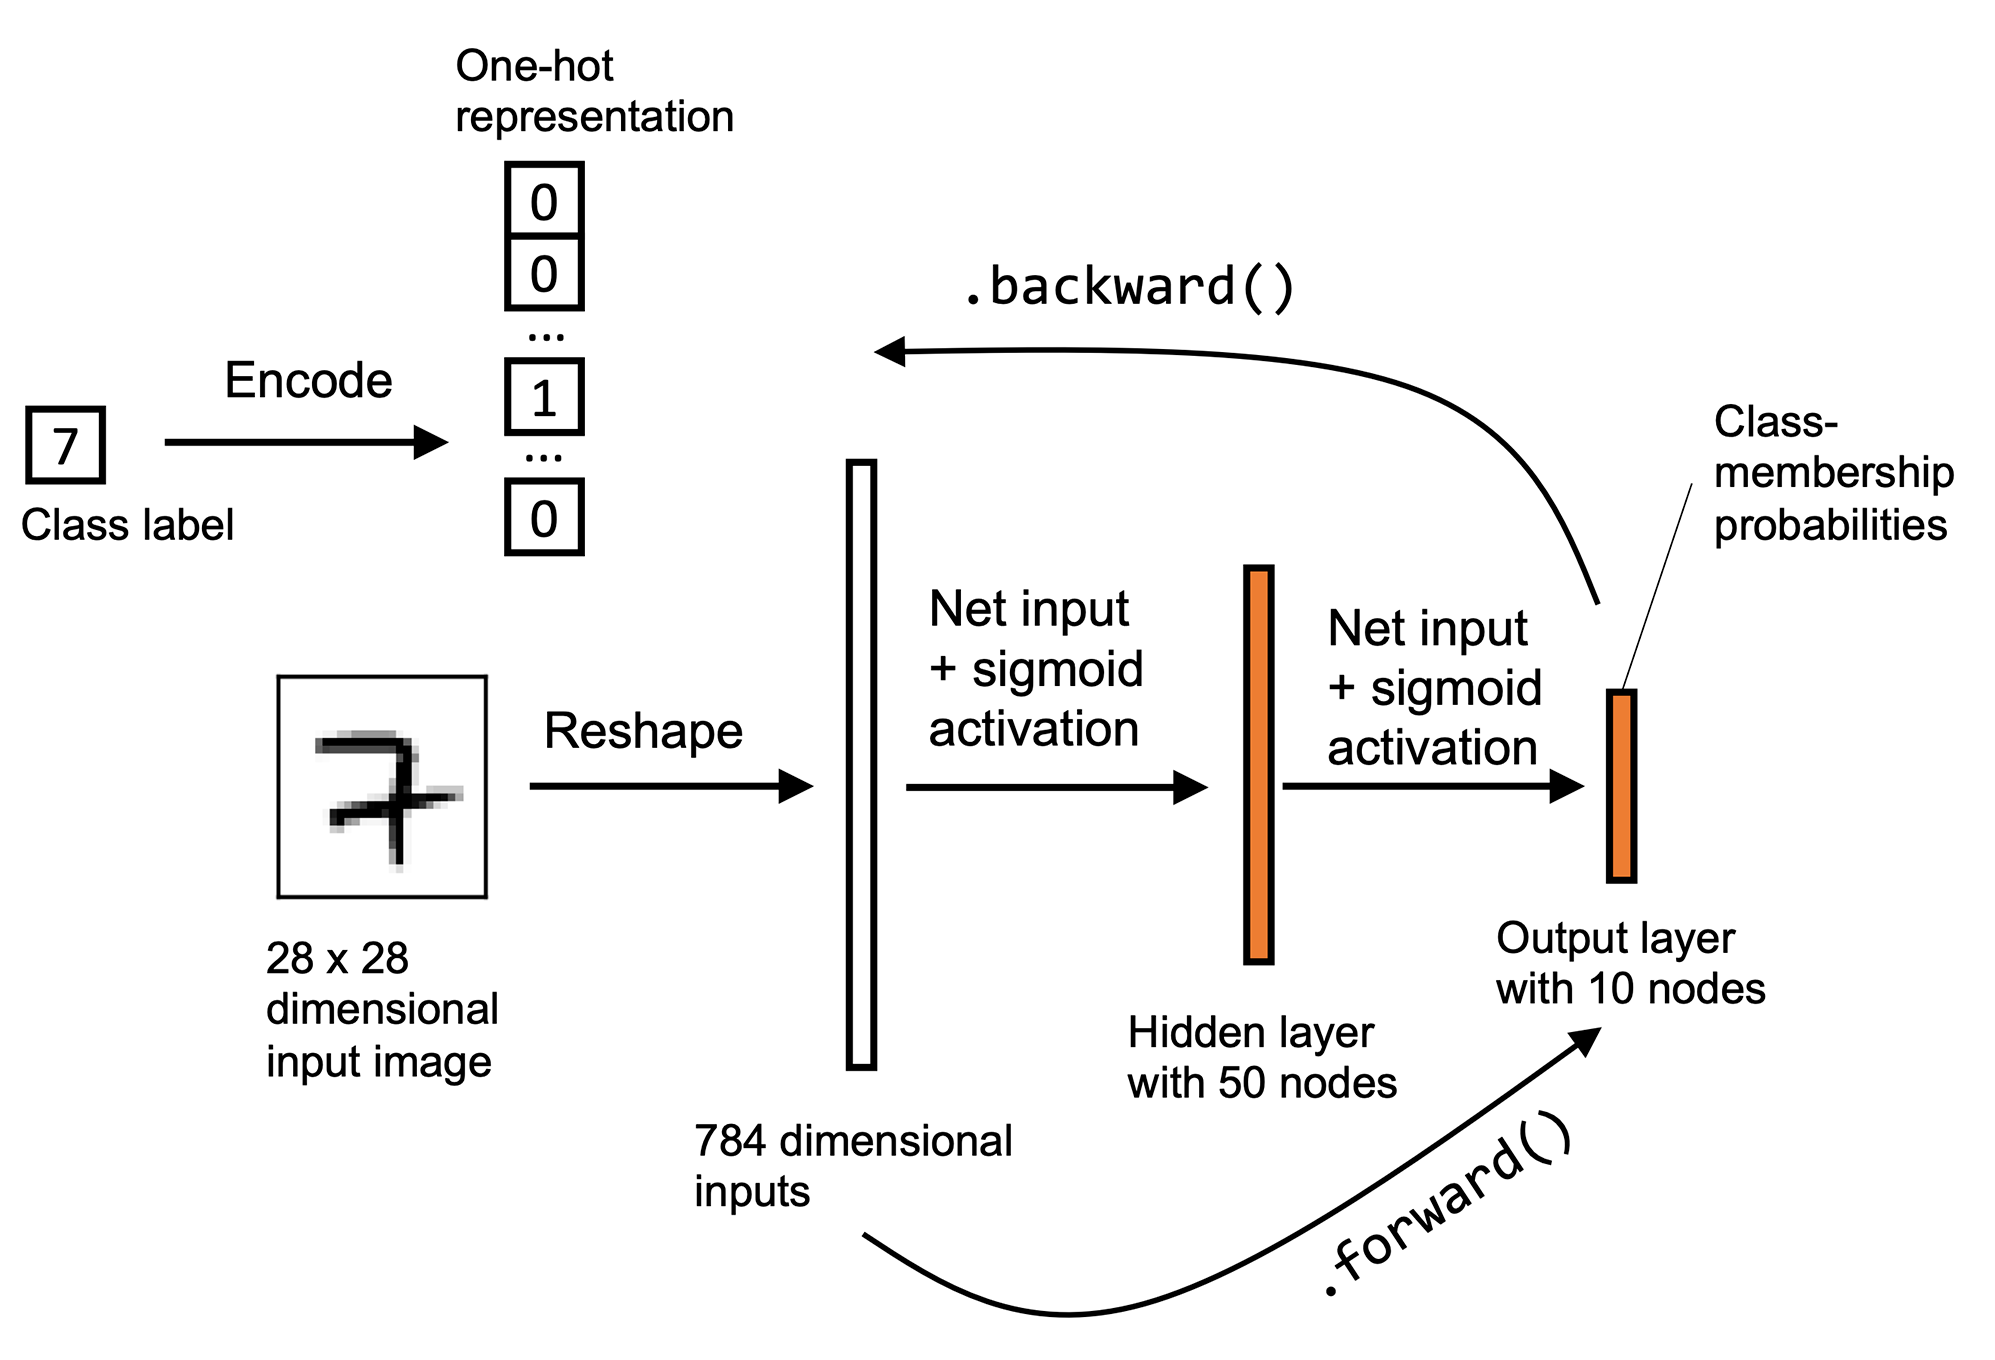

The NN architecture for labeling handwritten digits

## Coding the neural network training loop

Now that we have implemented the NeuralNetMLP class in the previous subsection and initiated a
model, the next step is to train the model. We will tackle this in multiple steps. First, we will define
some helper functions for data loading. Second, we will embed these functions into the training loop
that iterates over the dataset in multiple epochs.


The first function we are going to define is a mini-batch generator, which takes in our dataset and divides
it into mini-batches of a desired size for stochastic gradient descent training. The code is as follows:

In [315]:
import numpy as np

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)

  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

let’s confirm that the mini-batch generator works as intended
and produces mini-batches of the desired size.

In [316]:
# iterate over training epochs
for i in range(num_epochs):
  # iterate over minibatches
  minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
  for X_train_mini, y_train_mini in minibatch_gen:
    break
  break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Next, we have to define our loss function and performance metric that we can use to monitor the
training process and evaluate the model.

In [317]:
def mse_loss(targets, probas, num_labels=10):
  onehot_targets = int_to_onehot(targets, num_labels=num_labels)
  return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
  return np.mean(predicted_labels == targets)

Let’s test the preceding function and compute the initial validation set MSE and accuracy of the model
we instantiated in the previous section:

In [318]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.2%


## 📊 Evaluation Function: MSE and Accuracy

This function evaluates the performance of the trained neural network.

### ✅ What It Computes
- **Mean Squared Error (MSE)**: Measures how far the predictions are from the true one-hot labels.
- **Accuracy**: Percentage of correctly classified examples.

### 📘 Formula
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{\hat{y}}_i - \mathbf{y}_i)^2
$$
$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Examples}}
$$

Where:
- $ \hat{y}_i $: predicted output (after sigmoid)
- $ y_i $: one-hot encoded true label
- $ N $: total number of examples

### 🔁 Mini-Batch Processing
To handle large datasets efficiently, the data is processed in **mini-batches** using a generator.

In [319]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

lets test it

In [320]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.2%


Let’s now get to the main part and implement the code to train our model:

In [321]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)
            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.4f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

Let’s now execute this function to train our model for 50 epochs

In [322]:
np.random.seed(123)  # for the training set shuffling
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1
)

Epoch: 001/050 | Train MSE: 0.0011 | Train Acc: 11.51% | Valid Acc: 11.68%
Epoch: 002/050 | Train MSE: 0.0011 | Train Acc: 13.14% | Valid Acc: 13.26%
Epoch: 003/050 | Train MSE: 0.0010 | Train Acc: 13.59% | Valid Acc: 14.10%
Epoch: 004/050 | Train MSE: 0.0010 | Train Acc: 14.23% | Valid Acc: 14.72%
Epoch: 005/050 | Train MSE: 0.0010 | Train Acc: 14.81% | Valid Acc: 15.14%
Epoch: 006/050 | Train MSE: 0.0010 | Train Acc: 15.15% | Valid Acc: 15.62%
Epoch: 007/050 | Train MSE: 0.0010 | Train Acc: 14.71% | Valid Acc: 15.16%
Epoch: 008/050 | Train MSE: 0.0010 | Train Acc: 14.84% | Valid Acc: 15.38%
Epoch: 009/050 | Train MSE: 0.0010 | Train Acc: 14.87% | Valid Acc: 15.42%
Epoch: 010/050 | Train MSE: 0.0010 | Train Acc: 15.16% | Valid Acc: 15.76%
Epoch: 011/050 | Train MSE: 0.0010 | Train Acc: 15.45% | Valid Acc: 15.92%
Epoch: 012/050 | Train MSE: 0.0010 | Train Acc: 15.92% | Valid Acc: 16.54%
Epoch: 013/050 | Train MSE: 0.0010 | Train Acc: 16.28% | Valid Acc: 16.78%
Epoch: 014/050 | Train MS

In train(), we collected the training loss and the training and validation accuracy for each epoch so
that we can visualize the results using Matplotlib. Let’s look at the training MSE loss first:

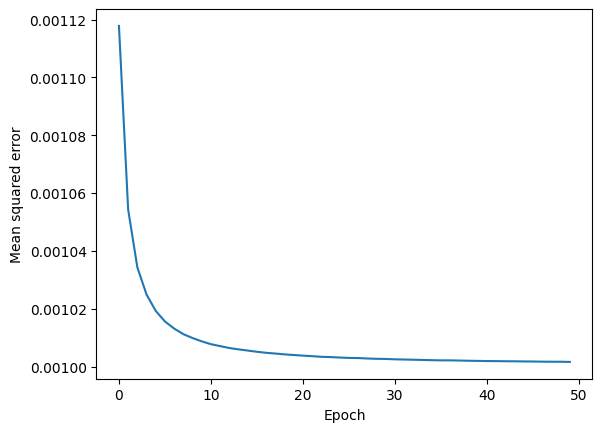

In [323]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

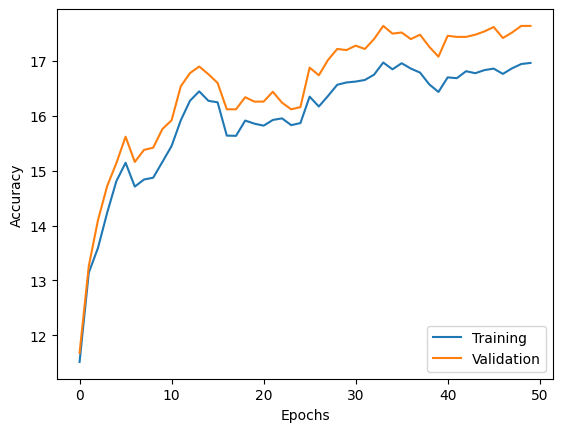

In [324]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [325]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 17.10%


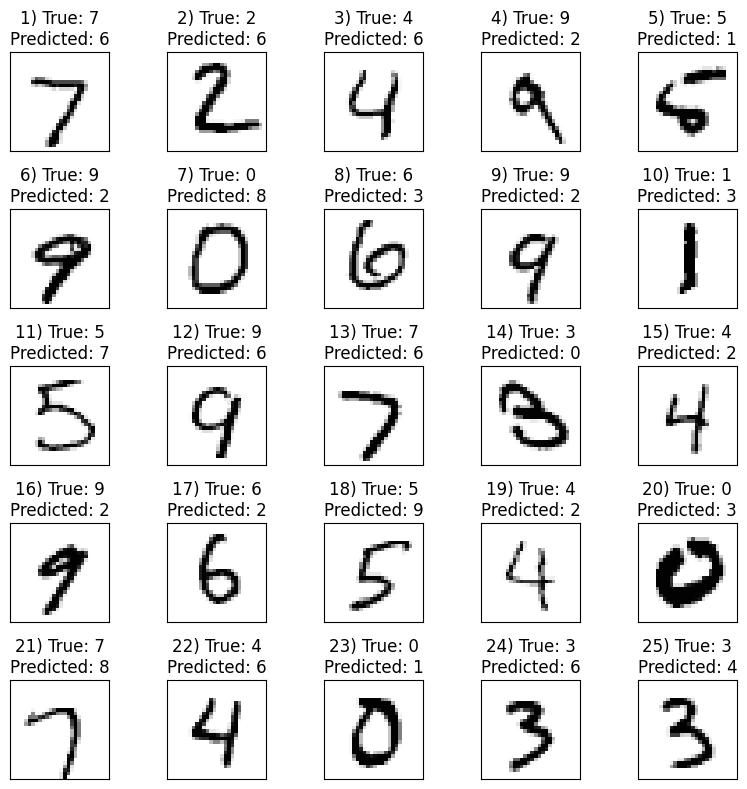

In [326]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5,
                      sharex=True, sharey=True,
                      figsize=(8, 8))
ax = ax.flatten()

for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) True: {correct_labels[i]}\nPredicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Building a multilayer perceptron for classifying flowers in the Iris dataset using PyT🔥rch

In [327]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()

X = iris['data']
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=50, random_state=1
)

In [328]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 4)
(100,)
(50, 4)
(50,)


In [329]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Normalize the training data
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

# Convert to PyTorch tensors
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)

# Create TensorDataset
train_ds = TensorDataset(X_train_norm, y_train)

# Set random seed for reproducibility
torch.manual_seed(1)

# Create DataLoader
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [330]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

# Model parameters
input_size = X_train_norm.shape[1]  # Number of input features
hidden_size = 16                     # Hidden layer size
output_size = 3                      # Number of output classes

# Instantiate the model
model = Model(input_size, hidden_size, output_size)

In [331]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [332]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        # Forward pass
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Track metrics
        loss_hist[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    # Calculate epoch averages
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

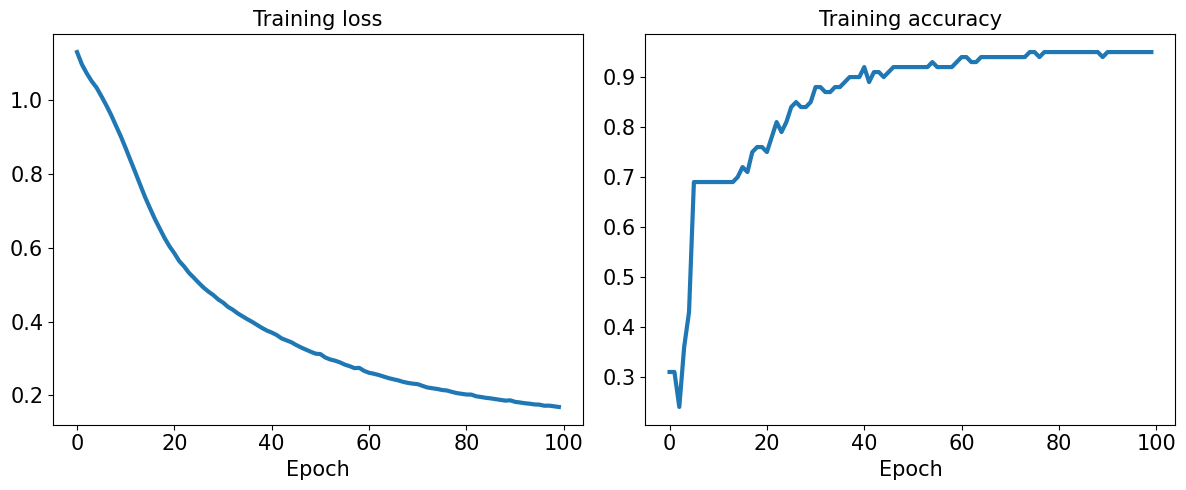

In [333]:
fig = plt.figure(figsize=(12, 5))

# Plot training loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# Plot training accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

In [334]:
# Normalize test data using training statistics
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)

# Get model predictions on test set
pred_test = model(X_test_norm)

# Calculate accuracy
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

# Print formatted accuracy
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.9800


## Implementing a deep CNN using PyTorch

The architecture of the network that we are going to implement is below. The inputs
are 28×28 grayscale images. Considering the number of channels (which is 1 for grayscale images)
and a batch of input images, the input tensor’s dimensions will be batchsize×28×28×1.

The architecture of the network that we are going to implement is:

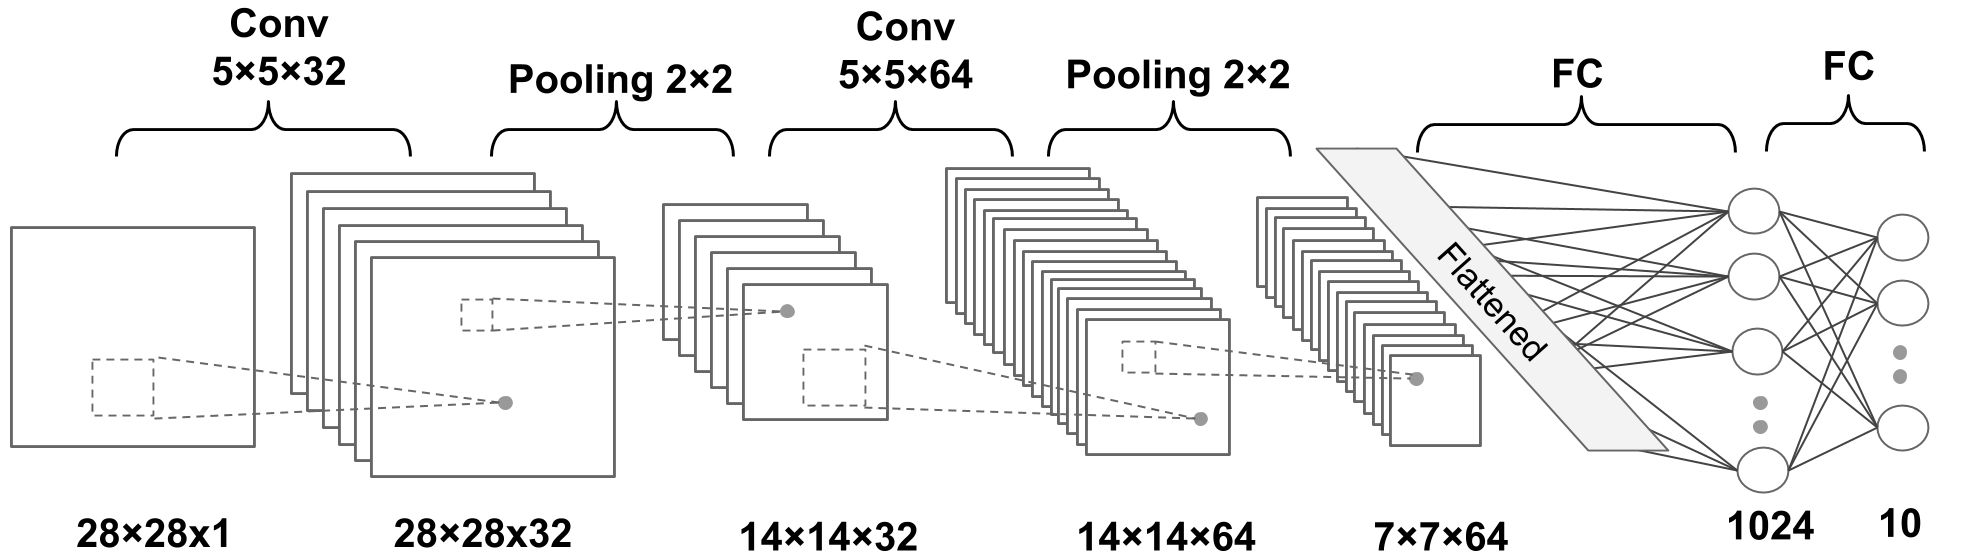

The MNIST dataset comes with a pre-specified training and test dataset partitioning scheme, but we
also want to create a validation split from the train partition. Hence, we used the first 10,000 training
examples for validation. Note that the images are not sorted by class label, so we do not have to worry
about whether those validation set images are from the same classes.

In [335]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset

# Define image transformations
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load full MNIST training dataset
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True
)

# Split into training (50,000) and validation (10,000) subsets
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

# Load test dataset (10,000 images)
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.81MB/s]


Next, we will construct the data loader with batches of 64 images for the training set and validation
set, respectively:

In [336]:
from torch.utils.data import DataLoader

# Set batch size and random seed
batch_size = 64
torch.manual_seed(1)

# Create training DataLoader with shuffling
train_dl = DataLoader(
    mnist_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Create validation DataLoader without shuffling
valid_dl = DataLoader(
    mnist_valid_dataset,
    batch_size=batch_size,
    shuffle=False
)

we can construct the CNN model that was shown in
the previous figure. In the following code, we will use the Sequential class and add the convolution
and pooling layers:

In [337]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [338]:
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [339]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Now we can train the model by defining the following function:

In [340]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')

    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Next, we will train this CNN model and use the validation
dataset that we created for monitoring the learning progress:

In [346]:
torch.manual_seed(1)
num_epochs = 6
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9965 val_accuracy: 0.9864
Epoch 2 accuracy: 0.9953 val_accuracy: 0.9900
Epoch 3 accuracy: 0.9916 val_accuracy: 0.9900
Epoch 4 accuracy: 0.9950 val_accuracy: 0.9905
Epoch 5 accuracy: 0.9961 val_accuracy: 0.9910
Epoch 6 accuracy: 0.9971 val_accuracy: 0.9907


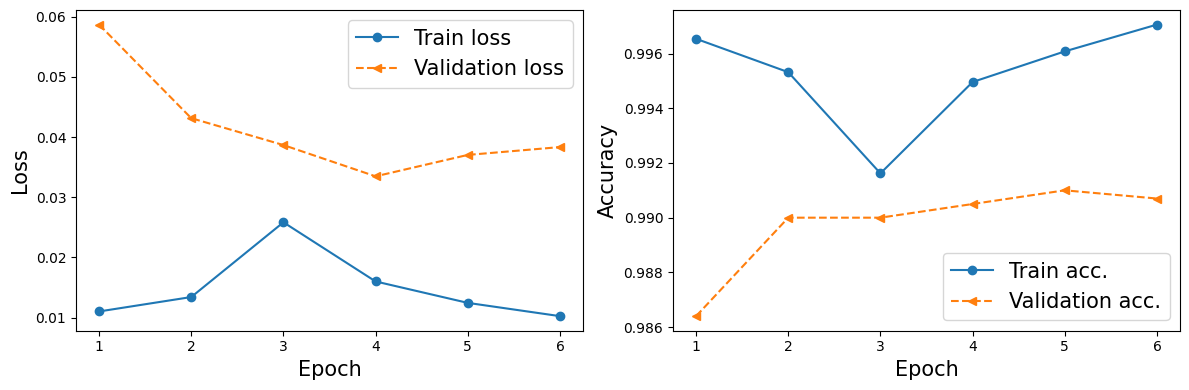

In [347]:
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

# Plot loss history
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

# Plot accuracy history
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.tight_layout()
plt.show()

In [348]:
# Prepare test data (add channel dimension and normalize)
test_images = mnist_test_dataset.data.unsqueeze(1) / 255.

# Get model predictions
pred = model(test_images)

# Calculate accuracy
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9925


The CNN model achieves an accuracy of 99.07 percent. Remember that in Chapter 13, we got approximately
95 percent accuracy using only fully connected (instead of convolutional) layers.

Finally, we can get the prediction results in the form of class-membership probabilities and convert
them to predicted labels by using the torch.argmax function to find the element with the maximum
probability. We will do this for a batch of 12 examples and visualize the input and predicted labels:

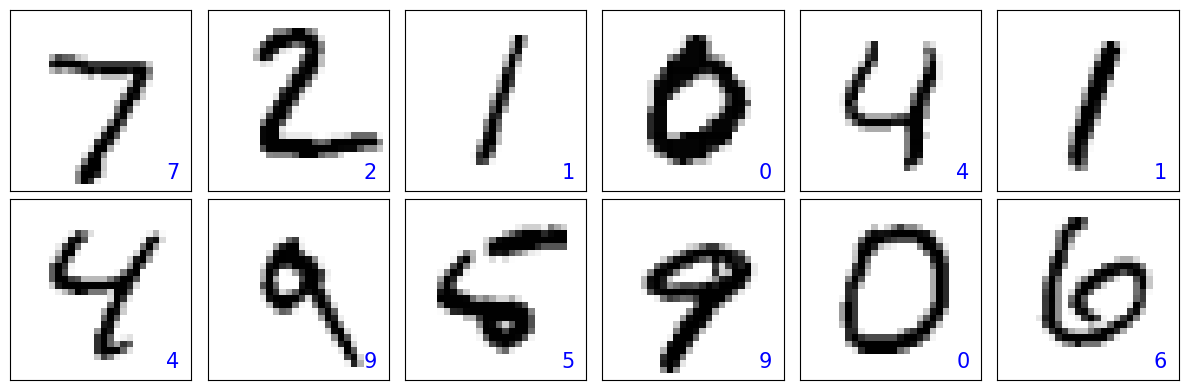

In [349]:
fig = plt.figure(figsize=(12, 4))

for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Get image and make prediction
    img = mnist_test_dataset[i][0][0, :, :]  # Get i-th image (remove channel dim)
    pred = model(img.unsqueeze(0).unsqueeze(1))  # Add batch and channel dims
    y_pred = torch.argmax(pred)

    # Display image and prediction
    ax.imshow(img, cmap='gray_r')
    ax.text(
        0.9, 0.1, y_pred.item(),
        size=15, color='blue',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()